# Taper example

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from zfel import sase1d

import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
DEFAULT_INPUT = dict(
    npart   = 512,                       # n-macro-particles per bucket 
    s_steps = 200,                      # n-sample points along bunch length
    z_steps = 200,                      # n-sample points along undulator
    energy  = 4313.34e6,                # electron energy [eV]
    eSpread = 0,                       # relative rms energy spread [1]
    emitN   = 1.2e-6,                    # normalized transverse emittance [m-rad]
    currentMax = 3900,                   # peak current [Ampere]
    beta = 26,                          # mean beta [meter]
    unduPeriod = 0.03,                 # undulator period [meter]
    unduK = np.full(200, 3.5) ,          # undulator parameter, K [1], array could taper. 
    unduL = 70,                         # length of undulator [meter]
    radWavelength=None,                 # Will calculate based on resonance condition for unduK[0]
    random_seed=31,                     # for reproducibility
    particle_position=np.genfromtxt('./Inputs/SASE_particle_position.csv', delimiter=','), # or None   
    hist_rule='square-root',             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \                                       #  of intervals to generate the histogram of eta value in a bucket
    iopt='sase'
)

In [4]:
def taper_output(unduK):
    '''
    Input:
    unduK is an array to represent taper profile (recommend to be a shape of (200,)
    
    Output:
    z is the position array along the undulator
    power_z is the output power along undulator
    '''
    
    sase_input = DEFAULT_INPUT.copy()
    
    sase_input['unduK'] = unduK
    sase_input['z_steps'] = unduK.shape[0]
    
    output = sase1d.sase(sase_input)
    
    z = output['z']
    power_z = output['power_z']
    
    return z, power_z    

# K array

In [5]:
MY_K_ARRAY = np.ones(200)*3.5

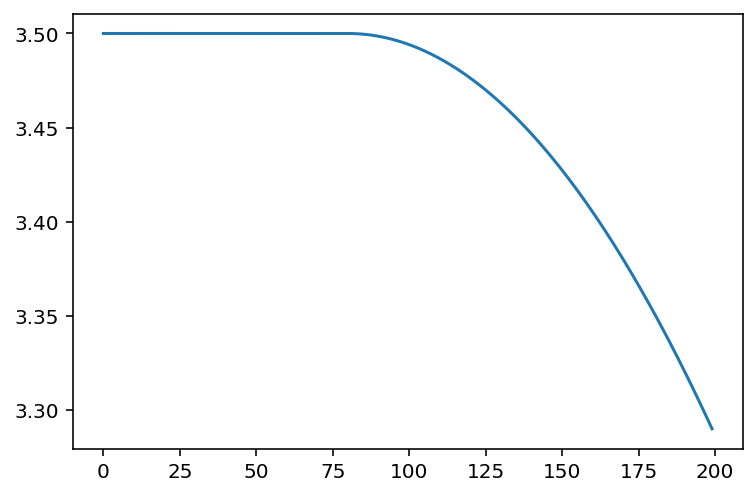

In [6]:
def k_taper(k0=3.5, a=0.5, n=200, split_ix=80):
    return np.hstack([np.ones(split_ix), (1- a*np.linspace(0, 1, n-split_ix)**2)])*k0
    
plt.plot(k_taper(a=.06))


# Run ZFEL

In [7]:
%%time
K0 = k_taper(a=0)
z, power0 =taper_output(K0)

CPU times: user 6.33 s, sys: 40.4 ms, total: 6.37 s
Wall time: 6.42 s


In [8]:
%%time
K1 = k_taper(a=0.06)
z, power1 =taper_output(K1)

CPU times: user 6.72 s, sys: 63.9 ms, total: 6.79 s
Wall time: 6.92 s


# Plot output

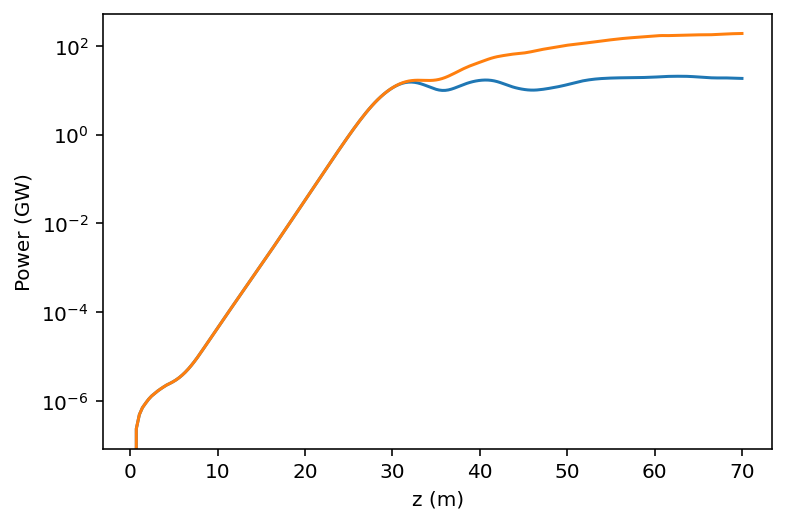

In [9]:
plt.xlabel('z (m)')
plt.ylabel('Power (GW)')
plt.yscale('log')
plt.plot(z,power0/1e9)
plt.plot(z,power1/1e9)

In [10]:
def run_taper(a):
    out = {}
    out['a'] = a
    out['k'] = k_taper(a=a)
    out['z'], out['power'] = taper_output(out['k'])
    return out

alist = np.linspace(0, .1, 10)
results = [run_taper(a) for a in alist] 

#from concurrent.futures import ProcessPoolExecutor
#executor = ProcessPoolExecutor(max_workers=1)

#results = list(executor.map(run_taper, alist ))

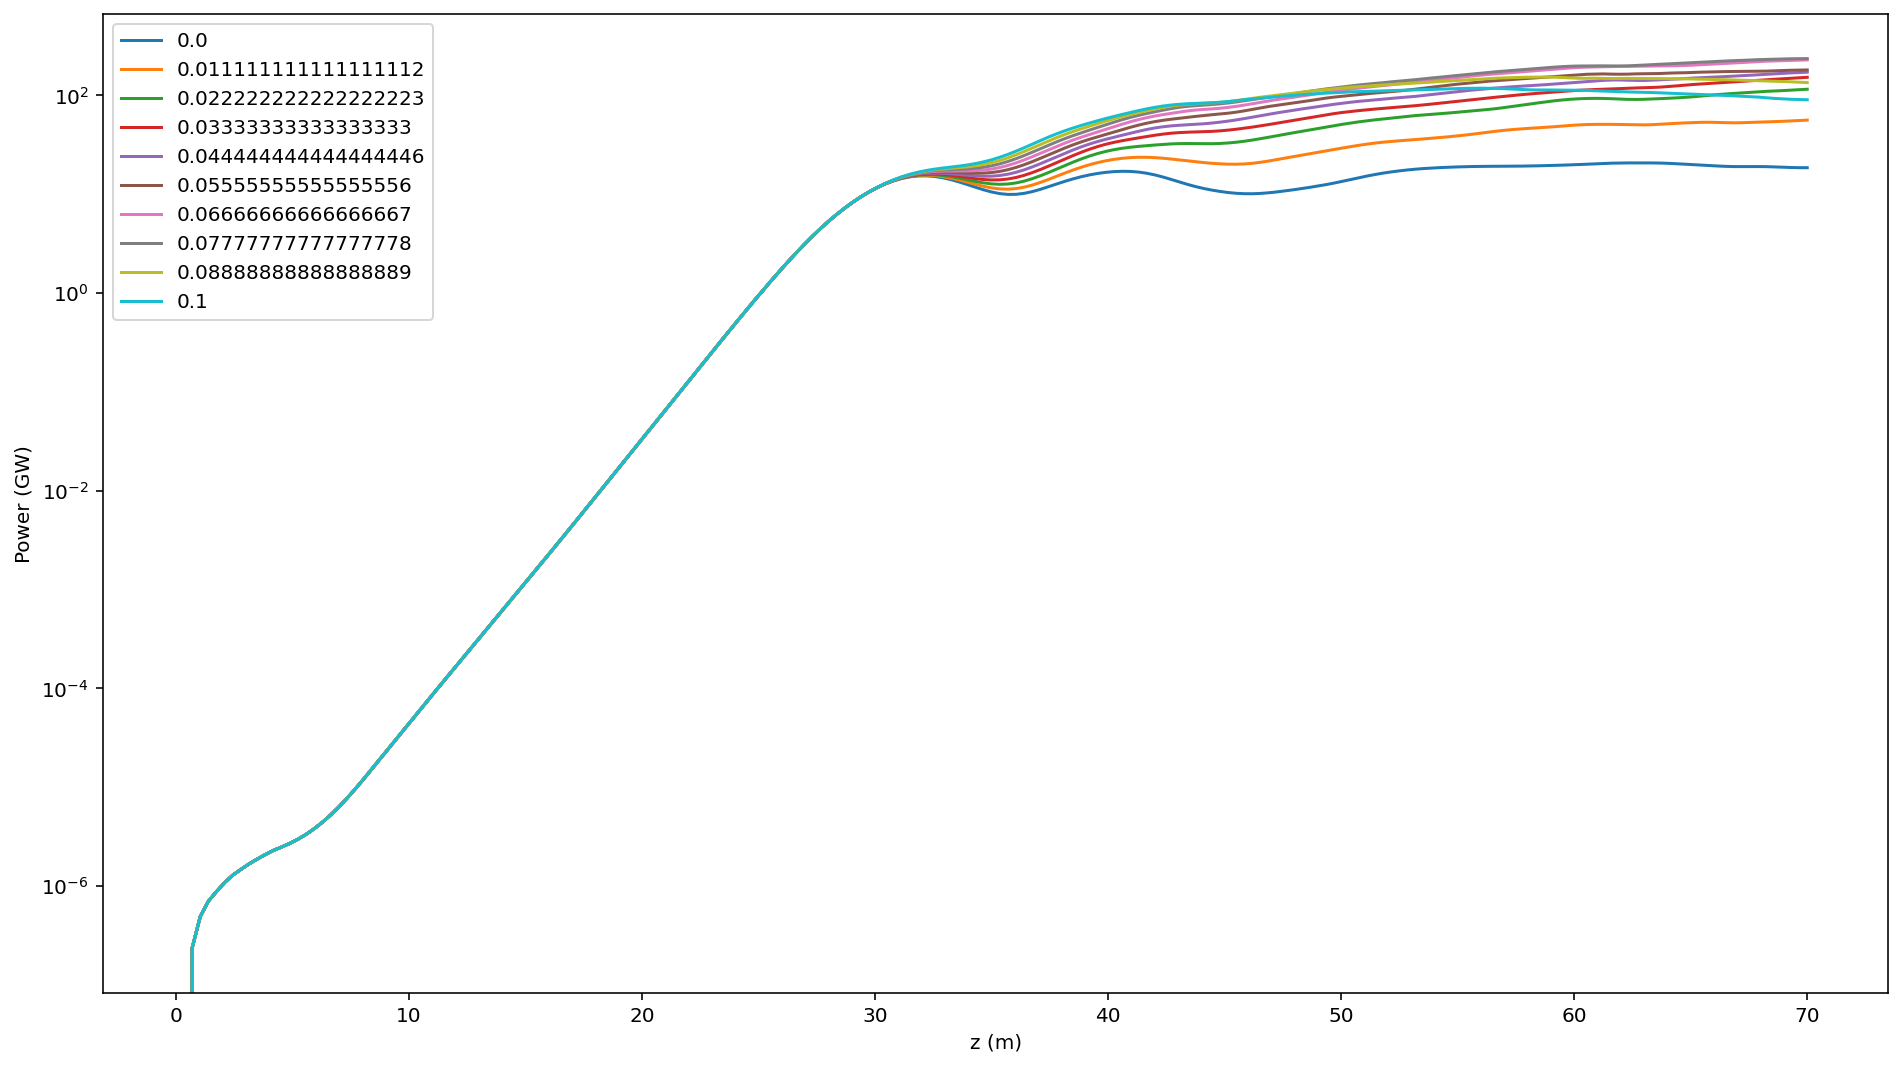

In [11]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_xlabel('z (m)')
ax.set_ylabel('Power (GW)')
for res in results:
    
    ax.plot(res['z'], res['power']/1e9, label=res['a'])

ax.set_yscale('log')
ax.legend()

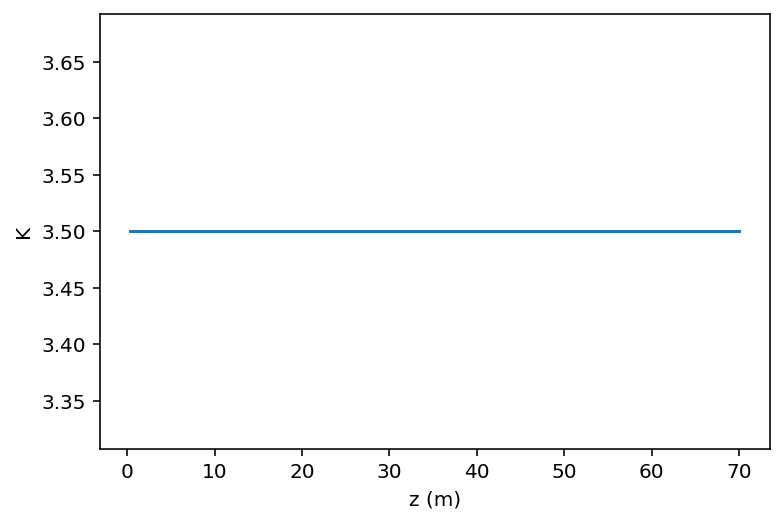

In [12]:
plt.ylabel('K')
plt.xlabel('z (m)')
plt.plot(z, MY_K_ARRAY)